In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.vision.image import *

## Data augmentation

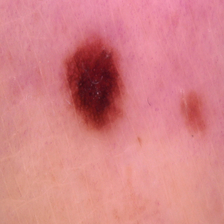

In [2]:
data_path = Path('/home/jupyter/skin-cancer-data')
im_path = data_path / 'train/benign/637.jpg'
im=open_image(im_path)
im

In [3]:
#tfms = get_transforms(max_rotate=180)
# The possible transformations are vertical and horizontal flips and 90-degree rotations.
tfms = get_transforms(do_flip=True, flip_vert=True)
def get_ex(): return im
""
def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

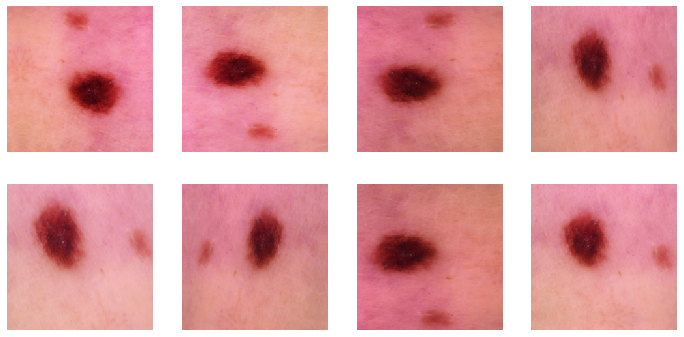

In [4]:
plots_f(2, 4, 12, 6, size=224)

## Defining the DataBunch object

In [5]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [7]:
train_path = (data_path / 'train').resolve()
data = (ImageList.from_folder(train_path)
        .split_by_rand_pct(valid_pct=0.2, seed=10)
        .label_from_folder()
        .transform(tfms)
        .databunch()
        .normalize())

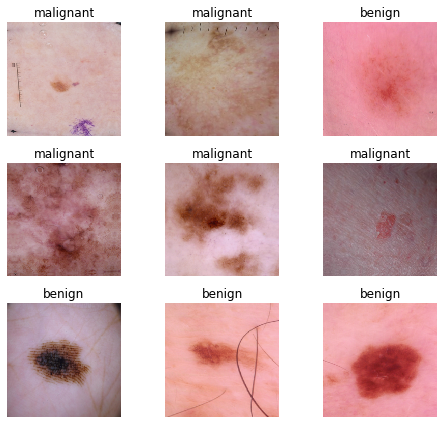

In [8]:
data.show_batch(rows=3, figsize=(7,6))

In [9]:
print(data.classes)

['benign', 'malignant']


In [10]:
data

ImageDataBunch;

Train: LabelList (2110 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
malignant,malignant,malignant,malignant,malignant
Path: /home/jupyter/skin-cancer-data/train;

Valid: LabelList (527 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
benign,benign,malignant,malignant,benign
Path: /home/jupyter/skin-cancer-data/train;

Test: None

## Training: ResNet34

In [11]:
model_dir = '/home/jupyter/models'
learn = cnn_learner(data, models.resnet34, pretrained=True, metrics=[accuracy], model_dir=model_dir)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jupyter/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 24.5MB/s]


In [12]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


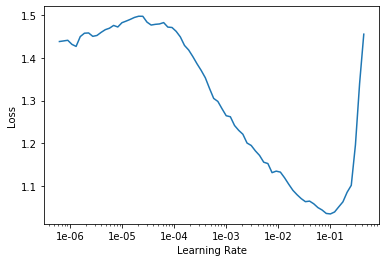

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
# This callback is necessary to record training loss with Dropout layers disabled.
# By default, when fit_one_cycle() records train_loss and accuracy, it is with Dropout enabled.
# This leads to misleading data when comparing to validation loss.
# This callback also:
# * saves model weights after each epoch
# * stores the epoch with the best validation accuracy.
class LossRecorderCB(Callback):
  def __init__(self):
    # Record [loss, accuracy] for train set
    self.record_train = {}
    # Record [loss, accuracy] for valid set
    self.record_valid = {}
    self.epoch = 1
    self.best_valid_acc = 0
    self.best_weights_epoch = -1

  def on_epoch_end(self, **kwargs):
    # We don't need to call learn.validate() on the validation set because it is already calculated correctly.
    self.record_valid[self.epoch] = kwargs['last_metrics']
    self.record_train[self.epoch] = learn.validate(data.train_dl)
    # Save weights as [epoch#].pth
    weights_path = learn.save(str(self.epoch), return_path=True)
    # If current validation accuracy is higher, update self.best_weights_epoch.
    cur_valid_acc = self.record_valid[self.epoch][1].item()
    if cur_valid_acc > self.best_valid_acc:
      self.best_valid_acc = cur_valid_acc
      self.best_weights_epoch = self.epoch

    self.epoch += 1


In [15]:
LRCB = LossRecorderCB()

In [16]:
learn.fit_one_cycle(40, max_lr=slice(1e-5,1e-3), callbacks=[LRCB])

In [17]:
print(LRCB.best_weights_epoch)
print(LRCB.best_valid_acc)

30
0.9032257795333862


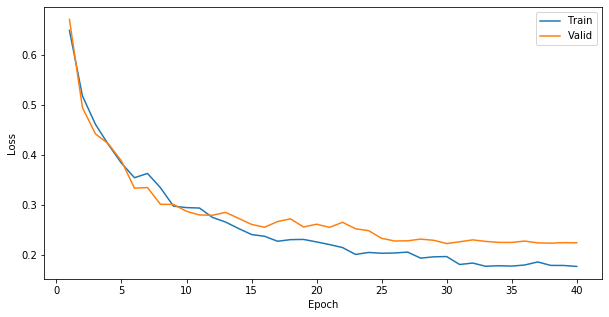

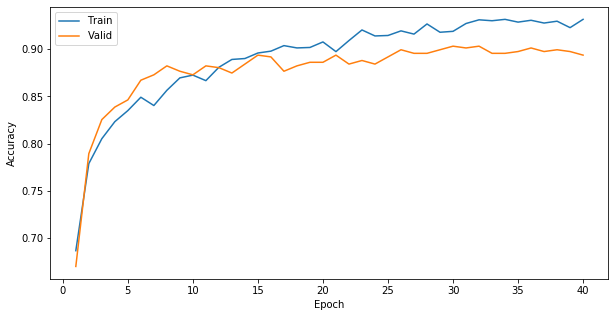

In [18]:
# Input: record_train or record_valid object
# Output: dictionary with keys: epochList, lossList, accList
def unpackRecord(rec):
  ret = {}
  ret['epochList'] = []
  ret['lossList'] = []
  ret['accList'] = []
  for k, v in rec.items():
    ret['epochList'].append(k)
    ret['lossList'].append(v[0])
    ret['accList'].append(v[1].item())
  return ret

def plotLRCB(LRCB):
  trainDict = unpackRecord(LRCB.record_train)
  validDict = unpackRecord(LRCB.record_valid)
  figsize = (10, 5)

  fig, ax1 = plt.subplots(1, 1, figsize=figsize)
  ax1.plot(trainDict['epochList'], trainDict['lossList'], label='Train')
  ax1.plot(validDict['epochList'], validDict['lossList'], label='Valid')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()

  fig, ax2 = plt.subplots(1, 1, figsize=figsize)
  ax2.plot(trainDict['epochList'], trainDict['accList'], label='Train')
  ax2.plot(validDict['epochList'], validDict['accList'], label='Valid')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

plotLRCB(LRCB)

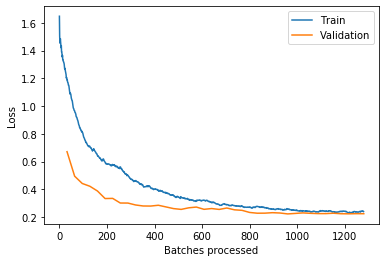

In [19]:
# This plot shows training loss as higher than validation loss.
# The reason is that Dropout is enabled during training.
# Also, it plots the moving average of the losses during training, so it has some traces of using bad weights near the beginning.
learn.recorder.plot_losses()

## Unfreezing, fine-tuning, and adjusting learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


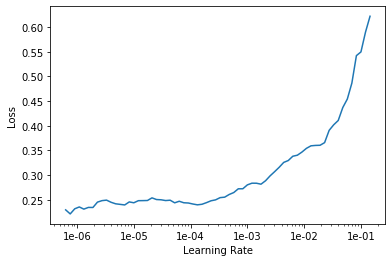

In [20]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.unfreeze()
learn.fit_one_cycle(40, max_lr=slice(1e-6,1e-4), callbacks=[LRCB])

In [23]:
print(LRCB.best_weights_epoch)
print(LRCB.best_valid_acc)

80
0.9240986704826355


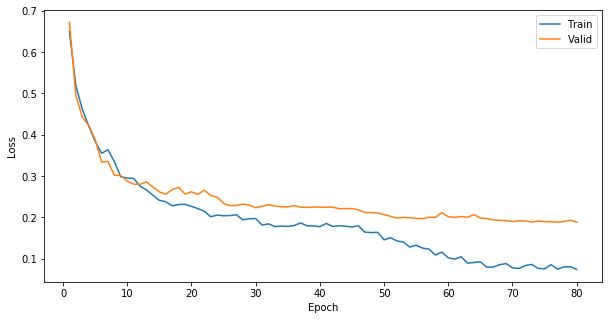

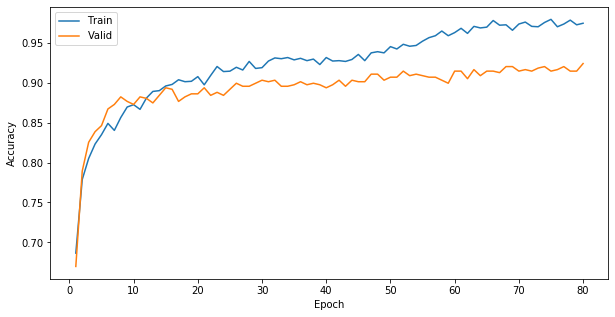

In [22]:
plotLRCB(LRCB)

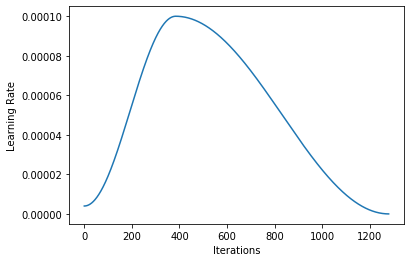

In [25]:
learn.recorder.plot_lr()

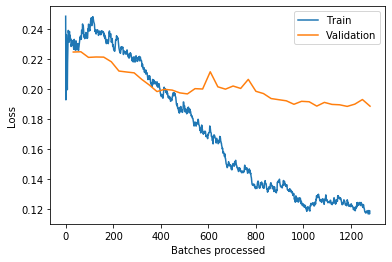

In [26]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


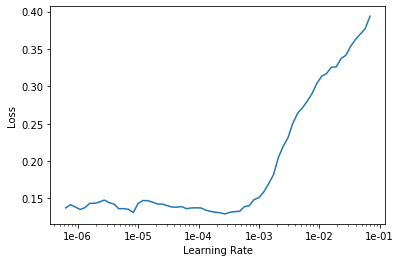

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(40, max_lr=slice(1e-6,1e-4), callbacks=[LRCB])

In [29]:
print(LRCB.best_weights_epoch)
print(LRCB.best_valid_acc)

117
0.9278937578201294


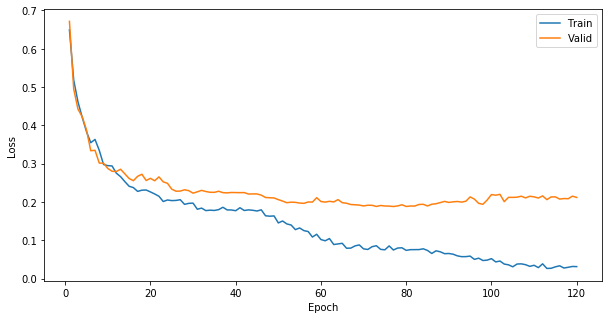

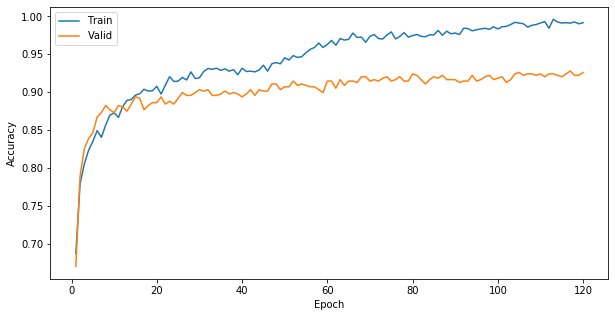

In [30]:
plotLRCB(LRCB)

In [31]:
print(LRCB.record_train)
print(LRCB.record_valid)

{1: [0.64944804, tensor(0.6865)], 2: [0.5184306, tensor(0.7788)], 3: [0.46159813, tensor(0.8052)], 4: [0.42089394, tensor(0.8232)], 5: [0.3839541, tensor(0.8350)], 6: [0.3548037, tensor(0.8491)], 7: [0.36337662, tensor(0.8403)], 8: [0.3347427, tensor(0.8564)], 9: [0.29795852, tensor(0.8696)], 10: [0.2950163, tensor(0.8726)], 11: [0.294163, tensor(0.8667)], 12: [0.27537698, tensor(0.8809)], 13: [0.26618397, tensor(0.8892)], 14: [0.25327566, tensor(0.8901)], 15: [0.24117199, tensor(0.8960)], 16: [0.23768818, tensor(0.8979)], 17: [0.22776112, tensor(0.9038)], 18: [0.23096064, tensor(0.9014)], 19: [0.23137875, tensor(0.9019)], 20: [0.22640526, tensor(0.9077)], 21: [0.22103801, tensor(0.8975)], 22: [0.21506311, tensor(0.9092)], 23: [0.20135123, tensor(0.9204)], 24: [0.20535064, tensor(0.9141)], 25: [0.20373416, tensor(0.9146)], 26: [0.20420875, tensor(0.9194)], 27: [0.20606391, tensor(0.9160)], 28: [0.19395705, tensor(0.9268)], 29: [0.19655812, tensor(0.9180)], 30: [0.19711201, tensor(0.918

## Misclassified examples

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

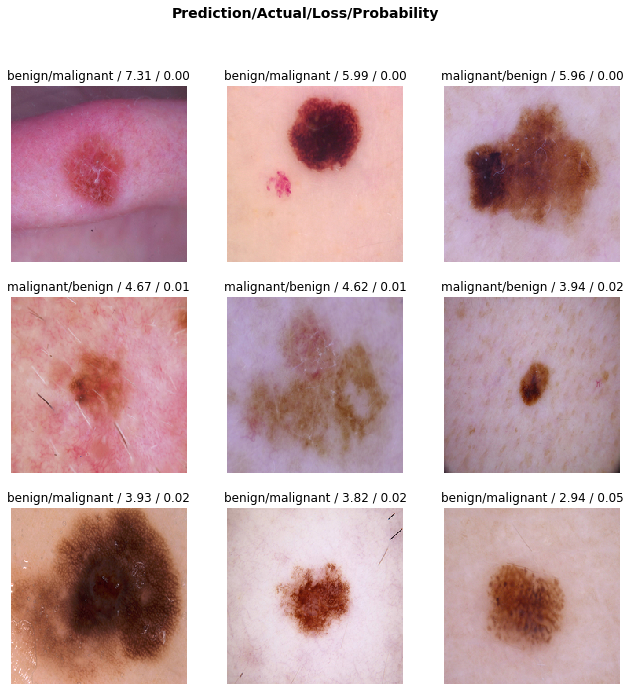

In [33]:
interp.plot_top_losses(9, figsize=(11,11))

## Evaluating test error

In [36]:
path = data_path.resolve()
test_metrics = [
  accuracy,
  Precision(average='binary', pos_label=1),
  Recall(average='binary', pos_label=1)
  ]
data_test = (ImageList.from_folder(path)
  .split_by_folder(train='test', valid='test')
  .label_from_folder()
  .databunch()
  .normalize()) 
# Return [loss, accuracy, precision, recall] for test set
learn.validate(data_test.valid_dl, metrics=test_metrics)

[0.28296968, tensor(0.9030), tensor(0.8907), tensor(0.8967)]

In [39]:
# checking category "malignant" is label 1
category = learn.data.train_ds[0][1]
print(category)
print(int(category))

malignant
1
